In [124]:
import math
import torch
import gpytorch
from cox_process import CoxProcess
from poisson_process import PoissonProcess
import sys
sys.path.append("../")
from kernels import SpaceKernel
import matplotlib.pyplot as plt

## Set up training data ##

In [125]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, lh):
        super().__init__(train_x, train_y, lh)
        # Define mean and kernel
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = SpaceKernel()

    def forward(self, times):
        mean = self.mean_module(times)
        covar = self.covar_module(times)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [126]:
r_bao = torch.tensor(100/0.7/1000) # Gpc
w_bao = torch.tensor(15/0.7/1000) # Gpc
print(r_bao)
print(w_bao)
raw_r_bao = torch.log(torch.exp(r_bao) - 1)
raw_w_bao = torch.log(torch.exp(w_bao) - 1)

lh = gpytorch.likelihoods.GaussianLikelihood()
sample_model = GPModel(None, None, lh)

sample_model.covar_module.raw_gauss_mean.data = torch.log(torch.exp(r_bao) - 1)
sample_model.covar_module.raw_gauss_sig.data = torch.log(torch.exp(w_bao) - 1)

tensor(0.1429)
tensor(0.0214)


In [128]:
sample_model.eval()
lh.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [132]:
intense_pts = torch.linspace(0, 10, 50).unsqueeze(-1)

intense_vals = sample_model(intense_pts).sample(sample_shape=torch.Size((1,))).squeeze()

In [137]:
proc = PoissonProcess(intense_pts, intense_vals)
sim = proc.simulate()

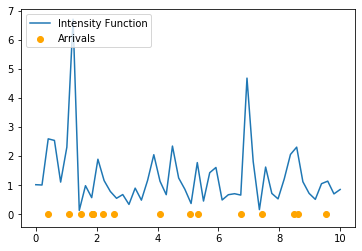

In [138]:
plt.plot(intense_pts, intense_vals.exp(), label="Intensity Function")
plt.scatter(sim, torch.zeros_like(sim), label="Arrivals", color="orange")
plt.legend(loc="upper left")

## Set Up Cox Process #

In [90]:
cox_proc = CoxProcess(intensity_grid=intense_pts, observations=sim)

#### Simulate

In [55]:
sim = proc.simulate()

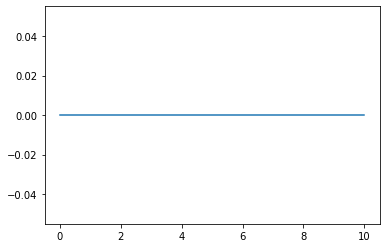

In [56]:
start = cox_proc.log_intensity
plt.plot(intense_pts, start.detach())

In [109]:
inferred = cox_proc.learn_intensity(sim, iters=2)

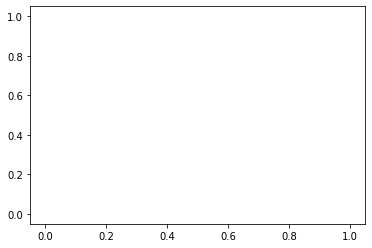

In [110]:
plt.plot(intense_pts, inferred.detach().exp())

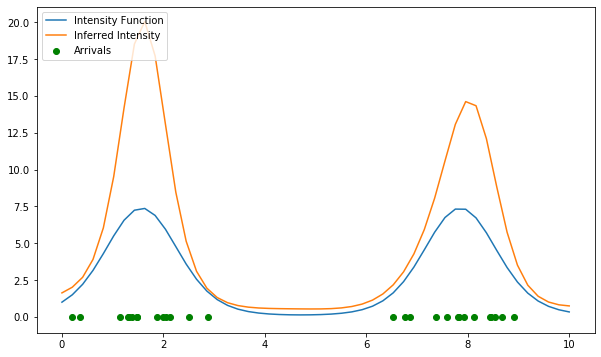

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(intense_pts, intense_vals.exp(), label="Intensity Function")
plt.scatter(sim.squeeze(), torch.zeros_like(sim), label="Arrivals", color="green")
plt.plot(intense_pts, inferred.detach().exp(), label="Inferred Intensity")
plt.legend(loc="upper left")

In [12]:
cox_proc.learn_hypers()

1.1401537656784058
1.0820082426071167
1.0296193361282349
0.9820500016212463
0.938433051109314
0.8980002403259277
0.8600708246231079
0.824009120464325
0.7891847491264343
0.7549558281898499
0.7207105159759521
0.6859548687934875
0.6504001021385193
0.6139945387840271
0.5768818855285645
0.5393123030662537
0.5015519857406616
0.46380889415740967
0.4261912405490875
0.38868844509124756
0.3511844277381897
0.3135078549385071
0.27549734711647034
0.23708389699459076
0.19831696152687073
0.15935875475406647
0.1204318255186081
0.08171859383583069
0.043286971747875214
0.005034332163631916
-0.03325660526752472
-0.07175514101982117
-0.11045295745134354
-0.14914222061634064
-0.18756408989429474
-0.22563530504703522
-0.2634654939174652
-0.30128195881843567
-0.339181512594223
-0.37707388401031494
-0.41475075483322144
-0.45205971598625183
-0.4890694320201874
-0.525977373123169
-0.562849223613739
-0.5995809435844421
-0.6359908580780029
-0.6720230579376221
-0.7078362107276917
-0.7434893250465393
-0.77893608808

## Test Stable Inference

In [112]:
cox_proc = CoxProcess(intensity_grid=intense_pts, observations=sim)

#### Simulate

In [113]:
sim = proc.simulate()

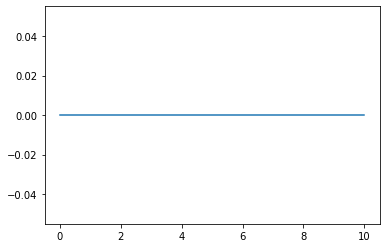

In [114]:
start = cox_proc.log_intensity
plt.plot(intense_pts, start.detach())

In [121]:
inferred = cox_proc.stable_learn_intensity(sim, iters=1)

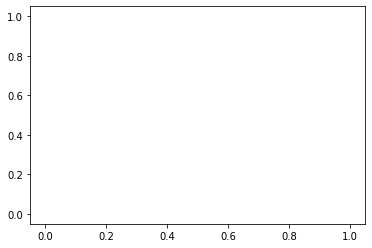

In [122]:
plt.plot(intense_pts, inferred.detach().exp())

In [19]:
cox_proc.learn_hypers()

1.5964072942733765
1.4607670307159424
1.3412917852401733
1.2358132600784302
1.1422514915466309
1.0587087869644165
0.9835219383239746
0.9152807593345642
0.8528170585632324
0.7951799035072327
0.7416014075279236
0.6914626955986023
0.6442639231681824
0.5995948314666748
0.5571125149726868
0.5165214538574219
0.47755783796310425
0.4399711489677429
0.4035182595252991
0.36795175075531006
0.33302417397499084
0.2984873950481415
0.26411399245262146
0.22970840334892273
0.19513389468193054
0.16030722856521606
0.1251884400844574
0.08972083777189255
0.05371955782175064
0.016768721863627434
-0.02189018204808235
-0.06330054998397827
-0.10843498259782791
-0.15748146176338196
-0.20910827815532684
-0.26048317551612854
-0.30849188566207886
-0.3513873219490051
-0.3895067572593689
-0.42453286051750183
-0.45843344926834106
-0.49291497468948364
-0.5291526317596436
-0.5677863359451294
-0.6089774370193481
-0.6524872779846191
-0.6977781057357788
-0.7440735697746277
-0.7904199957847595
-0.8357980847358704
-0.879229

In [23]:
covar_mod = gpytorch.kernels.GridKernel(gpytorch.kernels.RBFKernel(), grid=grid)